In [2]:
# Importing the necessary libraries

import numpy as np 
from matplotlib import pyplot as plt 
import keras 
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os 
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.image as mpimg
import seaborn as sns
from lime import lime_image
import time
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import pandas as pd
from keras.applications.vgg16 import preprocess_input
import datetime
%matplotlib inline


Using TensorFlow backend.


In [3]:
# Add the training and test dataset path

TRAIN_PATH = "Dataset/Train Data"
TEST_PATH = "Dataset/Test Data"

# Mention the image dimensions

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [4]:
# Build the CNN MODEL

model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model.add((Conv2D(64, (3, 3), activation = 'relu')))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
________________________________________________

In [5]:
#Augment the images of the training dataset 
train_datagen = image.ImageDataGenerator(
    rescale = 1./ 255,
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = True)

# Resize to improve linearity of the test dataset 
test_datagen = image.ImageDataGenerator(rescale = 1. / 255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH), 
    batch_size = 32, 
    class_mode = 'binary'
)

train_generator.class_indices

Found 284 images belonging to 2 classes.


{'Covid': 0, 'Non-Covid': 1}

In [7]:
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = 32, 
    class_mode = 'binary')

test_generator.class_indices

Found 115 images belonging to 2 classes.


{'Covid': 0, 'Non-Covid': 1}

In [8]:
#Add checkpointers to improve accuracy

checkpointer = keras.callbacks.ModelCheckpoint(model, verbose = 1, save_best_only = True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callback = [keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_accuracy'),
            keras.callbacks.TensorBoard(histogram_freq = 0, log_dir = log_dir )]

In [9]:
#Train the model

hist = model.fit_generator(
    train_generator, 
    steps_per_epoch = 8, 
    epochs = 10, 
    validation_data = test_generator, 
    validation_steps = 2,
    verbose = 1,
    callbacks = callback)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8/8 [==============================] - ETA: 1:48 - loss: 0.6912 - accuracy: 0.56 - ETA: 1:02 - loss: 1.3922 - accuracy: 0.59 - ETA: 1:07 - loss: 1.2829 - accuracy: 0.59 - ETA: 1:02 - loss: 1.1459 - accuracy: 0.60 - ETA: 40s - loss: 1.0589 - accuracy: 0.5813 - ETA: 24s - loss: 0.9940 - accuracy: 0.574 - ETA: 10s - loss: 0.9457 - accuracy: 0.581 - 84s 10s/step - loss: 0.9122 - accuracy: 0.5992 - val_loss: 0.6916 - val_accuracy: 0.5312
Epoch 2/10
8/8 [==============================] - ETA: 32s - loss: 0.7115 - accuracy: 0.406 - ETA: 27s - loss: 0.6967 - accuracy: 0.468 - ETA: 23s - loss: 0.6885 - accuracy: 0.500 - ETA: 18s - loss: 0.6799 - accuracy: 0.572 - ETA: 13s - loss: 0.6701 - accuracy: 0.628 - ETA: 8s - loss: 0.6661 - accuracy: 0.638 - ETA: 4s - loss: 0.6596 - accuracy: 0.65 - 37s 5s/step - loss: 0.6528 - accuracy: 0.6548 - val_loss: 0.6216 - val_accuracy: 0.7843
Epoch 3/10
8/8 [==============================] - ETA: 32s - 

In [10]:
# Save the model 

model.save("my_model.h5")

In [11]:
# Display the training accuracy

model.evaluate_generator(train_generator)

[0.16605544090270996, 0.9683098793029785]

In [12]:
#Dispay the validation accuracy 

model.evaluate_generator(test_generator)

[0.5521382093429565, 0.7565217614173889]

In [13]:
model = load_model('my_model.h5')
y_test = []
y_actual = []


In [14]:

for i in os.listdir("Dataset/Test Data/Non-Covid/"):
    img = image.load_img("Dataset/Test Data/Non-Covid/" + i, target_size = (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    p = model.predict_classes(img)
    y_test.append(p[0, 0])
    y_actual.append(1)
    
for i in os.listdir("Dataset/Test Data/Covid/"):
    img = image.load_img("Dataset/Test Data/Covid/" + i, target_size = (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    p = model.predict_classes(img)
    y_test.append(p[0, 0])
    y_actual.append(0)

In [15]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [16]:
cm = confusion_matrix(y_actual, y_test)


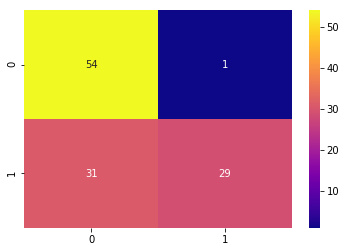

In [17]:
#Plot the confusion matrix

sns.heatmap(cm, cmap = 'plasma', annot = True)
plt.show()

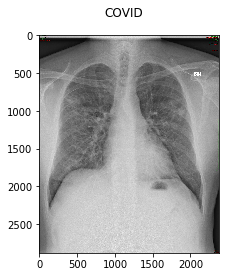

In [19]:
# Predict the results from the Covid Test Data

img_src = 'Dataset/Test Data/Covid/covid-19-caso-70-1-PA.jpg'
img = cv2.imread(img_src)

img_pred = image.load_img(img_src, target_size = (224, 224))
img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = model.predict(img_pred)

ind = train_generator.class_indices

if rslt[0][0] == 1:
    prediction = "Non-COVID"
else:
    prediction = "COVID"

target_width = 50
target_height = 50
target_size = (target_width, target_height)

img = cv2.resize(img, target_size)
img = img.reshape(1, target_width, target_height, 3)


fig, ax = plt.subplots()
fig.suptitle(prediction, fontsize=12)

np_img = mpimg.imread(img_src)
plt.imshow(np_img)

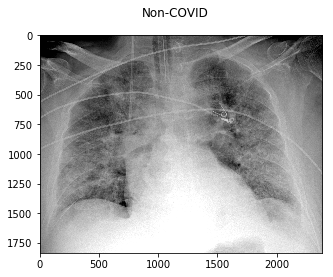

In [51]:
# Predict the result from the Non-Coivd Test Data

img_src = 'Dataset/Test Data/Non-Covid/IM-0089-0001.jpeg'
img = cv2.imread(img_src)

img_pred = image.load_img(img_src, target_size = (224, 224))
img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = model.predict(img_pred)

ind = train_generator.class_indices

if rslt[0][0] == 1:
    prediction = "Non-COVID"
else:
    prediction = "COVID"

target_width = 50
target_height = 50
target_size = (target_width, target_height)

img = cv2.resize(img, target_size)
img = img.reshape(1, target_width, target_height, 3)


fig, ax = plt.subplots()
fig.suptitle(prediction, fontsize=12)

plt.imshow(np_img)

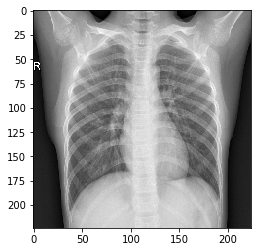

In [106]:
img_src = 'Dataset/Test Data/Non-Covid/IM-0089-0001.jpeg'

img = cv2.imread(img_src)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

In [107]:
# Showing the various focused portions based on LIME

explainer = lime_image.LimeImageExplainer()

In [108]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)
print(time.time() - tmp)

46.957757234573364


In [109]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

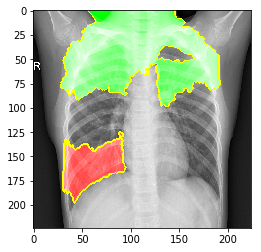

In [110]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask))

In [111]:
# Displaying heat maps 

def cam(img_path):
    
    K.clear_session()
    
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
  
    x = preprocess_input(x)
    preds = model.predict(x)
  
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
   
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'Dataset/Test Data/Covid/covid-19-pneumonia-12.jpg'
    cv2.imwrite(output, superimposed_img)
    
    mymodel = load_model('my_model.h5')
    rslt = mymodel.predict(x)
    #print(rslt)
    if rslt[0][0] == 1:
        prediction = "Non-COVID"
    else:
        prediction = "COVID"
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(prediction)
    return None

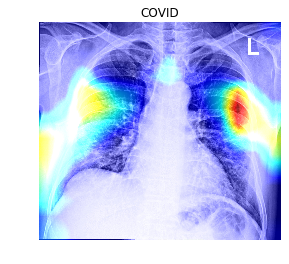

In [112]:
cam('Dataset/Test Data/Covid/covid-19-pneumonia-30-PA.jpg')

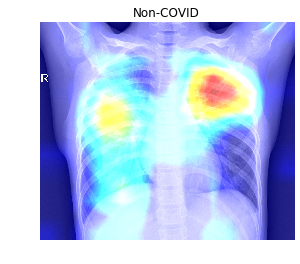

In [113]:
cam('Dataset/Test Data/Non-Covid/IM-0089-0001.jpeg')